In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import random

%matplotlib inline 

In [2]:
df_sp = pd.read_csv("../../data/spicata_clean.csv")
df_sp.head()

,Unnamed: 0,id,time_observed_at,user_id,created_at,quality_grade,num_identification_agreements,num_identification_disagreements,captive_cultivated,latitude,...,species_guess,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff
0,0,39481,2007-04-14 16:48:00+00:00,477,2011-11-18 18:32:06+00:00,research,1,0,False,36.294893,...,Pickerel Frog,Lithobates palustris,Pickerel Frog,Animalia,Lithobates,Lithobates palustris,0,0,-1.000000e-03,-0.001000
1,1,4914407,2009-08-10 20:10:00+00:00,477,2017-01-08 21:14:11+00:00,research,2,0,False,-23.137390,...,Atlantic Ghost Crab,Ocypode quadrata,Atlantic Ghost Crab,Animalia,Ocypode,Ocypode quadrata,0,0,1.222762e+06,7553.014945
2,2,8755,2010-11-01 03:52:00+00:00,477,2010-11-01 04:04:18+00:00,research,0,0,False,37.740688,...,Argentinian biddy biddy,Acaena pinnatifida,Argentinian biddy biddy,Plantae,Acaena,Acaena pinnatifida,0,0,6.441420e+05,10598.859075
3,3,10565,2011-01-26 18:14:01+00:00,477,2011-01-26 19:08:52+00:00,research,3,0,False,37.428551,...,Toyon,Heteromeles arbutifolia,Toyon,Plantae,Heteromeles,Heteromeles arbutifolia,0,0,1.247020e+05,41.604820
4,4,10566,2011-01-26 19:16:39+00:00,477,2011-01-26 19:17:41+00:00,research,1,0,False,37.428566,...,wild radish,Raphanus sativus,wild radish,Plantae,Raphanus,Raphanus sativus,0,0,6.263333e+01,0.037091


# Quick Touchup
Even though the dataset was cleaned in the Spicata_Clean_and_Prep notebook, there are a few things to tweak due to a process of saving as a csv.

In [3]:
# when I saved to csv, it encoded the index as it's own column--need to drop
df_sp.drop("Unnamed: 0", axis = 1, inplace = True)


In [4]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148243 entries, 0 to 148242
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                148243 non-null  int64  
 1   time_observed_at                  148243 non-null  object 
 2   user_id                           148243 non-null  int64  
 3   created_at                        148243 non-null  object 
 4   quality_grade                     148243 non-null  object 
 5   num_identification_agreements     148243 non-null  int64  
 6   num_identification_disagreements  148243 non-null  int64  
 7   captive_cultivated                148243 non-null  bool   
 8   latitude                          148243 non-null  float64
 9   longitude                         148243 non-null  float64
 10  positional_accuracy               148243 non-null  float64
 11  public_positional_accuracy        148243 non-null  f

In [5]:
# convert time objects to UTC datetimes
df_sp["time_observed_at"] = pd.to_datetime(df_sp["time_observed_at"], utc = True)
df_sp["created_at"] = pd.to_datetime(df_sp["created_at"], utc = True)

# Timestamps
How does the "time_observed_at" date relate to or diverge from "time_created_at"? \
[A brief history of iNaturalist is given here for context.](https://www.inaturalist.org/pages/about#:~:text=iNaturalist.org%20began%20as%20the,School%20of%20Information%20in%202008.)

In [6]:
print(f'Earliest observation date: {df_sp["time_observed_at"].min()};\n\
Last observation date: {df_sp["time_observed_at"].max()}')
print(f'Earliest observation created at: {df_sp["created_at"].min()}; \n\
Last observation created at: {df_sp["created_at"].max()}')

Earliest observation date: 1983-02-01 20:35:00+00:00;
Last observation date: 2023-12-26 19:42:44+00:00
Earliest observation created at: 2010-11-01 04:04:18+00:00; 
Last observation created at: 2023-12-26 23:38:28+00:00


In [7]:
# How many observations predate earliest "created_at" time?
(df_sp["time_observed_at"]<df_sp["created_at"].min()).sum()

2327

In [8]:
# How many users have observations predating earliest "created_at" time?
df_sp[df_sp["time_observed_at"]<df_sp["created_at"].min()]["user_id"].nunique()

9

In [9]:
# How many observations predate iNaturalist existing?
(df_sp["time_observed_at"]<'2008-01-01').sum()

491

In [10]:
# How many users have observations predating iNaturalist existing?
df_sp[df_sp["time_observed_at"]<'2008-01-01']["user_id"].nunique()

9

In [11]:
# How many posts did each of these users with early observations have 
# that predate the first "created_at" date of the set?
early_posters = df_sp[df_sp["time_observed_at"]<'2008-01-01']["user_id"].unique() # set of users with early posts
for i in range(len(early_posters)):
    early_obs = df_sp[(df_sp["user_id"] == early_posters[i])  
                      & (df_sp["time_observed_at"]<df_sp["created_at"].min())]\
                .sort_values("created_at").shape[0]
    print(f'User {early_posters[i]} posted {early_obs} observation(s) prior to {df_sp["created_at"].min()}')

User 477 posted 3 observation(s) prior to 2010-11-01 04:04:18+00:00
User 604 posted 426 observation(s) prior to 2010-11-01 04:04:18+00:00
User 11792 posted 27 observation(s) prior to 2010-11-01 04:04:18+00:00
User 392818 posted 87 observation(s) prior to 2010-11-01 04:04:18+00:00
User 434504 posted 24 observation(s) prior to 2010-11-01 04:04:18+00:00
User 518143 posted 1287 observation(s) prior to 2010-11-01 04:04:18+00:00
User 1237597 posted 78 observation(s) prior to 2010-11-01 04:04:18+00:00
User 1262660 posted 3 observation(s) prior to 2010-11-01 04:04:18+00:00
User 2125177 posted 392 observation(s) prior to 2010-11-01 04:04:18+00:00


In [12]:
# How many posts did each of these users with early observations have
# that predate iNaturalist existing?
for i in range(len(early_posters)):
    even_earlier_obs = df_sp[(df_sp["user_id"] == early_posters[i]) \
                      & (df_sp["time_observed_at"]< '2008-01-01')]\
                .sort_values("created_at").shape[0]
    print(f'User {early_posters[i]} posted {even_earlier_obs} observation(s) prior to 2008, when iNaturalist began.')

User 477 posted 1 observation(s) prior to 2008, when iNaturalist began.
User 604 posted 16 observation(s) prior to 2008, when iNaturalist began.
User 11792 posted 15 observation(s) prior to 2008, when iNaturalist began.
User 392818 posted 9 observation(s) prior to 2008, when iNaturalist began.
User 434504 posted 16 observation(s) prior to 2008, when iNaturalist began.
User 518143 posted 160 observation(s) prior to 2008, when iNaturalist began.
User 1237597 posted 20 observation(s) prior to 2008, when iNaturalist began.
User 1262660 posted 3 observation(s) prior to 2008, when iNaturalist began.
User 2125177 posted 251 observation(s) prior to 2008, when iNaturalist began.


In [13]:
# When did these users with early observations first begin posting on iNaturalist?
for i in range(len(early_posters)):
    first_post = df_sp[df_sp["user_id"] == early_posters[i]]["created_at"].min()
    print(f'User {early_posters[i]} first posted on {first_post}')

User 477 first posted on 2010-11-01 04:04:18+00:00
User 604 first posted on 2011-02-18 05:29:32+00:00
User 11792 first posted on 2012-12-22 19:08:46+00:00
User 392818 first posted on 2017-03-14 03:07:12+00:00
User 434504 first posted on 2017-03-27 16:56:45+00:00
User 518143 first posted on 2017-06-26 16:17:20+00:00
User 1237597 first posted on 2018-09-27 10:27:50+00:00
User 1262660 first posted on 2018-12-27 16:38:42+00:00
User 2125177 first posted on 2019-08-13 03:51:22+00:00


Case Study of one "early_poster" shows that first 9 initial observations were posted the day after the observations were made--likely from the same "hike" but after that, and within the first two days of their initial post, the user began to post "backlog" observations, first from that same year, but then going back through previous years.

In [14]:
df_sp[df_sp["user_id"] == early_posters[8]].sort_values("created_at").head(30)

,id,time_observed_at,user_id,created_at,quality_grade,num_identification_agreements,num_identification_disagreements,captive_cultivated,latitude,longitude,...,species_guess,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff
116527,30731759,2019-08-12 05:45:00+00:00,2125177,2019-08-13 03:51:22+00:00,needs_id,1,0,False,35.483582,-87.339920,...,Efferia,Efferia,not stated,Animalia,Efferia,not stated,0,0,1.000000,0.022760
116522,30731761,2019-08-12 04:24:00+00:00,2125177,2019-08-13 03:51:22+00:00,research,1,0,False,35.483464,-87.339844,...,Citrine Forktail,Ischnura hastata,Citrine Forktail,Animalia,Ischnura,Ischnura hastata,0,0,1.000000,0.020289
116521,30731760,2019-08-12 04:23:00+00:00,2125177,2019-08-13 03:51:22+00:00,research,1,0,False,35.483327,-87.339992,...,Citrine Forktail,Ischnura hastata,Citrine Forktail,Animalia,Ischnura,Ischnura hastata,0,0,27.000000,0.018741
116526,30731763,2019-08-12 05:44:00+00:00,2125177,2019-08-13 03:51:23+00:00,research,1,0,False,35.483412,-87.340060,...,Common Eastern Bumble Bee,Bombus impatiens,Common Eastern Bumble Bee,Animalia,Bombus,Bombus impatiens,0,0,49.000000,0.098689
116525,30731764,2019-08-12 04:55:00+00:00,2125177,2019-08-13 03:51:23+00:00,research,1,0,False,35.482526,-87.340124,...,Funereal Duskywing,Erynnis funeralis,Funereal Duskywing,Animalia,Erynnis,Erynnis funeralis,0,0,21.000000,0.107186
116519,30731765,2019-08-12 03:46:00+00:00,2125177,2019-08-13 03:51:24+00:00,research,1,0,False,35.483438,-87.339800,...,Funereal Duskywing,Erynnis funeralis,Funereal Duskywing,Animalia,Erynnis,Erynnis funeralis,0,0,346.000000,0.036145
116524,30731766,2019-08-12 04:34:00+00:00,2125177,2019-08-13 03:51:25+00:00,research,4,0,False,35.483462,-87.339841,...,Hoary Edge,Thorybes lyciades,Hoary Edge,Animalia,Thorybes,Thorybes lyciades,0,0,3.000000,0.056364
116520,30731767,2019-08-12 03:56:00+00:00,2125177,2019-08-13 03:51:25+00:00,research,1,0,False,35.483417,-87.339817,...,Ocola Skipper,Panoquina ocola,Ocola Skipper,Animalia,Panoquina,Panoquina ocola,0,0,10.000000,0.002797
116523,30731768,2019-08-12 04:31:00+00:00,2125177,2019-08-13 03:51:26+00:00,research,1,0,False,35.482959,-87.339918,...,Tawny-edged Skipper,Polites themistocles,Tawny-edged Skipper,Animalia,Polites,Polites themistocles,0,0,7.000000,0.056552
116465,30813503,2019-07-20 22:01:03+00:00,2125177,2019-08-14 15:20:39+00:00,research,1,0,False,45.119649,-109.296978,...,Weidemeyer's Admiral,Limenitis weidemeyerii,Weidemeyer's Admiral,Animalia,Limenitis,Limenitis weidemeyerii,0,0,79.283333,62.317102


In [15]:
# What percent of observations were posted more than d number of days after the observation was made?
percent_by_time_gap_in_days = {} #create dictionary holding d and the related percent
for d in range(366): # two years worth of numbers
    num_posts = ((df_sp["created_at"] - df_sp["time_observed_at"]).dt.total_seconds() / (24 * 3600) <= d).sum() 
    percent = round(100 * num_posts / df_sp.shape[0],1)
    percent_by_time_gap_in_days[d] = percent 
    
days_after_obs = [1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 365] # print out specific data points
for d in days_after_obs:
    print(f'{percent_by_time_gap_in_days[d]}% of observations are posted within {d} day(s) after the observation was made.')

66.6% of observations are posted within 1 day(s) after the observation was made.
75.2% of observations are posted within 2 day(s) after the observation was made.
79.9% of observations are posted within 3 day(s) after the observation was made.
84.5% of observations are posted within 5 day(s) after the observation was made.
89.2% of observations are posted within 10 day(s) after the observation was made.
91.6% of observations are posted within 20 day(s) after the observation was made.
92.3% of observations are posted within 30 day(s) after the observation was made.
92.7% of observations are posted within 50 day(s) after the observation was made.
93.3% of observations are posted within 100 day(s) after the observation was made.
93.8% of observations are posted within 200 day(s) after the observation was made.
94.3% of observations are posted within 365 day(s) after the observation was made.


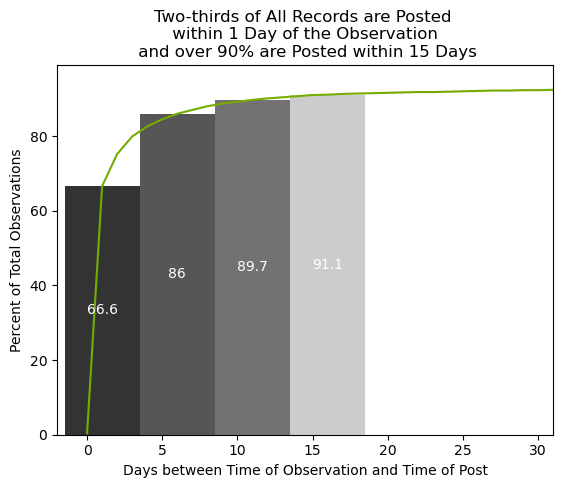

In [16]:
time_gaps_to_highlight = [1, 6, 11, 16]
percent_to_highlight = [percent_by_time_gap_in_days[i] for i in time_gaps_to_highlight]
plt.figure()
plt.plot(list(percent_by_time_gap_in_days.keys()),
         list(percent_by_time_gap_in_days.values()),
         color = '#74ac00' )
plt.xlim(xmin = -2, xmax = 31)
b = plt.bar(time_gaps_to_highlight, 
        percent_to_highlight, 
        color = ['#333333', '#565656', '#727272', '#CCCCCC'],
        width = 5)
plt.bar_label(b, label_type = "center", color = 'white')
plt.xlabel("Days between Time of Observation and Time of Post")
plt.ylabel("Percent of Total Observations")
plt.title("Two-thirds of All Records are Posted \n \
within 1 Day of the Observation \n and over 90% are Posted within 15 Days")
plt.show()


Suggested code for time efficient way of grouping datetimes by year used below was in [this Stackoverview thread.](https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column)

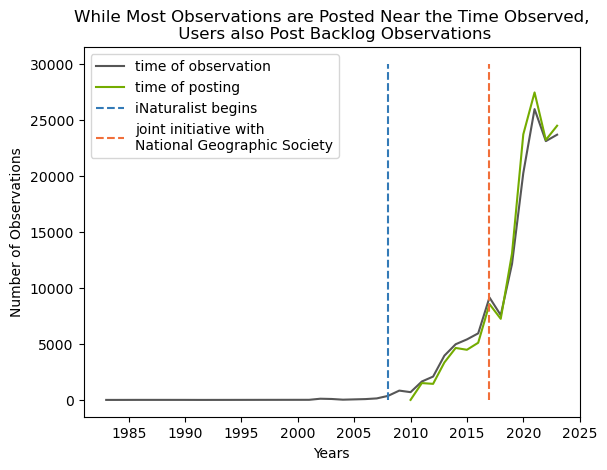

In [17]:
# creating a count of entries by year groupings based on time_observed_at and time created_at
obs_time_by_year = df_sp.groupby(df_sp["time_observed_at"].map(lambda x: x.year))["id"].count()
created_time_by_year = df_sp.groupby(df_sp["created_at"].map(lambda x: x.year))["id"].count()

#plotting the two to compare
plt.figure()
plt.plot(obs_time_by_year.index, obs_time_by_year.values, label = "time of observation", color = '#565656' )
plt.plot(created_time_by_year.index, created_time_by_year.values, label = "time of posting", color = '#74ac00')
plt.vlines(2008, 0, 30000, color = '#337AB7' , label = "iNaturalist begins", linestyle = "dashed")
plt.vlines(2017, 0, 30000, color = '#f16f3a' , label = "joint initiative with \nNational Geographic Society", linestyle = "dashed")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Number of Observations")
plt.title("While Most Observations are Posted Near the Time Observed,\n Users also Post Backlog Observations")
plt.show()


# Numerical Summary

In [18]:
round(df_sp.describe(),3)

,id,user_id,num_identification_agreements,num_identification_disagreements,latitude,longitude,positional_accuracy,public_positional_accuracy,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff
count,1.482430e+05,148243.000,148243.000,148243.000,148243.000,148243.000,148243.000,148243.000,148243.000,148243.000,148243.000,148243.000
mean,7.583246e+07,1102011.150,1.118,0.007,38.519,-86.872,309.448,2667.019,0.058,0.021,1749.765,28.404
std,5.899573e+07,1080513.991,0.934,0.088,8.661,26.867,13168.038,15048.029,0.234,0.142,27436.864,297.634
min,8.755000e+03,477.000,0.000,0.000,-43.110,-159.795,0.000,0.000,0.000,0.000,-0.001,-0.001
25%,2.083244e+07,11792.000,1.000,0.000,37.054,-94.779,5.000,5.000,0.000,0.000,1.167,0.012
50%,7.103309e+07,805798.000,1.000,0.000,40.685,-84.928,10.000,11.000,0.000,0.000,4.767,0.094
75%,1.230358e+08,1883226.000,2.000,0.000,42.643,-76.258,98.000,244.000,0.000,0.000,34.133,2.667
max,1.949334e+08,5800322.000,15.000,3.000,58.513,153.419,2703477.000,2703477.000,1.000,1.000,6661710.917,17744.088


__id__ Because each unique id is assigned to observations consecutively in real time based on "created_at", the distribution of ids still gives us some information about this set, although not much that isn't told better by the range of "created_at" category. It does help us contextualize these observations inside of the larger iNaturalist community by showing us how many more observations were also being contributed over that space of time. \
__user_id__ Similar idea here, because unique ids are assigned consecutively based on when users create accounts, the range of user_ids show us the 70 users we have span from early to recent adopters. Above, we see user 477's first post was in 2010 before iNaturalist became an LLC, while below we see that user 5800322's first post was in 2022. 

In [19]:
df_sp[df_sp["user_id"] == 5800322].head(1)

,id,time_observed_at,user_id,created_at,quality_grade,num_identification_agreements,num_identification_disagreements,captive_cultivated,latitude,longitude,...,species_guess,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff
147770,121729765,2022-06-13 20:05:25+00:00,5800322,2022-06-14 13:34:27+00:00,casual,0,0,False,35.538799,-83.49395,...,not stated,Rhododendron calendulaceum,Flame Azalea,Plantae,Rhododendron,Rhododendron calendulaceum,0,0,-0.001,-0.001


__num_idenification_agreements__ 75% fall at 2 or below. Most likely because iNaturalist only requires two users to be in agreement at the species level for an observation to become "research grade", so long as no one disagrees. The culture of the community is to cease to add identifications to an observation once it reaches "research grade" unless someone disagrees. Only when there is disagreement is it common for others to contribute to help create a community consensus. I explored the unusual instance of "15" agreements in the Spicata_Clean_and_Prep notebook. Cross-referencing with iNaturalist postings shows that users were just very excited about the really quality/close picture of a mountain lion :-) \
__num_identification_disagreements__ Disagreements are recorded for fewer than 25% of the observations. This doesn't mean that disagreements didn't happen in the course of posting. It is common for disagreements to happen as an observation is first discussed among members. However, usually a community consensus emerges around one particular taxon_id and users usually withdraw old disagreeing posts and change their own guess at a taxon_id to reflect agreeement with others. Those "withdrawn", early disagreements are not included in this total. Additionally, iNaturalist visually marks users who are not swayed by community consensus a "Maverick" in the observation's public-facing post, which culturally encourages users to only keep disagreements in the face of an alternative community consensus if it is really well-considered. This part of the data story is not included in the dataset but can be helpful in explaining why so few observations show any disagreement in the "final" recording.\
__latitude and longitude__ Not sure that summary data is particularly helpful, but it is interesting to note that both the median and mean, when paired, show up in Indiana. The set was designed with the bias toward U.S. postings because all Lobelia Spicata plants targeted were located in the U.S. However, I do wonder if having the mean/median latitudes land us in Indiana suggests a heavier skew toward the eastern U.S. in this dataset. \
__positional_accuracy__ Both public and default(private), more than 50% of the data is inside the range of 30m or less for research. \
__geoprivacy_obscured__ Both for taxon and default(private), less than 75% of the data is obscured, which is also reflected in the positional accuracies because obscured geoprivacy usually sets positional accuracy at around 26000m or higher.

In [20]:
# What are the public positional accuracies of records with obscured coordinates?
round(df_sp[df_sp["coordinates_obscured"] == 1]["public_positional_accuracy"].describe(),0)

count      11144.0
mean       27777.0
std        16603.0
min            0.0
25%        27411.0
50%        27754.0
75%        28329.0
max      1600907.0
Name: public_positional_accuracy, dtype: float64

In [21]:
# What does the data look like for "obscured" records when positional accuracy is less than 26000m?
obscured = df_sp[df_sp["coordinates_obscured"] == 1]

obscured[obscured["public_positional_accuracy"] < 26000]\
[["created_at", "public_positional_accuracy","geoprivacy_obscured","taxon_geoprivacy_obscured", "taxon_species_name"]]

,created_at,public_positional_accuracy,geoprivacy_obscured,taxon_geoprivacy_obscured,taxon_species_name
340,2011-05-02 02:59:24+00:00,10000.0,0,1,Calochortus pulchellus
359,2011-05-09 17:30:18+00:00,10000.0,0,1,Horkelia marinensis
829,2012-02-26 05:33:37+00:00,10000.0,0,1,Ceanothus sonomensis
988,2012-04-09 04:32:13+00:00,5.0,0,1,Amazona ochrocephala
1072,2012-04-26 23:59:46+00:00,1414.0,0,1,Cephalophus dorsalis
...,...,...,...,...,...
37010,2019-05-21 21:59:12+00:00,61.0,0,1,Mergus serrator
40094,2017-04-09 13:59:59+00:00,5.0,0,1,Sarracenia flava
42194,2018-04-08 04:22:08+00:00,164.0,0,1,Asio flammeus
45605,2017-05-30 23:29:02+00:00,15.0,0,1,Sceptridium rugulosum


In [22]:
# How many of the 100 Lobelia spicata target species are impacted by this anomaly?
obscured[(obscured["public_positional_accuracy"] < 26000) \
         & ("taxon_species_name" == "Lobelia spicata")].shape[0]

0

It is difficult to understand what is happening for these 237 rows. Some might be due to the imputation of the mean I did in the last notebook, but that is not true for any of the observations shown in the head and tail above. This seems to be contradiction in some of the data--unless there are certain kinds of geoprivacy not noted here or in the materials I have read that allow for smaller positional accuracy ranges--the recordings here suggest that the data in at least one of the columns under consideration is incorrectly recorded. Is is a small percentage of rows, so I will work from the assumption that any mistakes in these rows will not significantly impact my analysis. Especially since none of the 100 target Lobelia spicata plants are in the set of anomalies. 

__min_diff__ Over 75% of the data is observed by a given user within 30 minutes of one another. It seems generally users do bursts of observations within 30 min of one another (such as a single "hike') and then let longer gaps of time go between those bursts. The quick look below shows that the 12 year gap for user 31314 is due to "back posting"--the user was uploading observations from many years prior, with large gaps in between some of them. \
__km_diff__ Over 75% of the data is observed by a given user within 2.7 km of one another. Most likely, this is the distance covered for a normal "hike" but it is also possible that users tend to go back to and only make observations in a certain area. \
*Note: the min is -0.001 because of imputation--that value indicates the first entry of any user's dataset where there wasn't yet a time or distance to record. I chose this value for imputation because it would act in summary data much like 0, but would also be able to be sorted out as a negative number or recognized if looked at individually.*

In [23]:
# What was going on with that really large time difference?
df_sp[df_sp["minute_diff"] > 6660000]

,id,time_observed_at,user_id,created_at,quality_grade,num_identification_agreements,num_identification_disagreements,captive_cultivated,latitude,longitude,...,species_guess,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff
31314,527876,2005-04-21 00:06:55+00:00,11792,2014-02-11 14:52:47+00:00,research,2,0,False,43.784639,-72.43371,...,Jefferson Salamander,Ambystoma jeffersonianum,Jefferson Salamander,Animalia,Ambystoma,Ambystoma jeffersonianum,0,1,6.661711e+06,261.550888


In [24]:
df_sp.iloc[31310:31320,0:4]

,id,time_observed_at,user_id,created_at
31310,20745138,1990-08-01 19:35:00+00:00,11792,2019-02-25 02:10:27+00:00
31311,20745127,1990-10-06 19:35:00+00:00,11792,2019-02-25 02:10:21+00:00
31312,20745133,1991-09-09 19:35:00+00:00,11792,2019-02-25 02:10:23+00:00
31313,20745139,1992-08-20 19:36:00+00:00,11792,2019-02-25 02:10:28+00:00
31314,527876,2005-04-21 00:06:55+00:00,11792,2014-02-11 14:52:47+00:00
31315,193888,2005-08-01 12:37:47+00:00,11792,2013-02-07 18:32:07+00:00
31316,197699,2007-02-09 20:56:14+00:00,11792,2013-02-13 19:33:51+00:00
31317,198398,2007-06-17 15:18:42+00:00,11792,2013-02-14 20:14:25+00:00
31318,179743,2008-10-09 15:53:33+00:00,11792,2013-01-14 19:28:10+00:00
31319,186379,2008-12-29 05:20:07+00:00,11792,2013-01-25 13:16:43+00:00


iNaturalist didn't begin until 2008 and this dataset doesn't have entries created before 2010. There is a large spike in numbers between 2018 and 2020. The 2020 spike can be attributed to the pandemic--many people, including myself, pursued new hobbies, especially those that allowed outdoor exploration. However, there was a large jump in 2019 as well. iNaturalist did start a joint initiative with National Geographic Society in 2017 and it's possible that this joint initiative manifested in a larger reach by 2019. \
Recent years show higher numbers for "time of posting"--because those posts include new observations and old observations, while less recent years show higher numbers of "time of observation" due to the posting of old observations from the past.

In [25]:
min_diff_for_analysis = df_sp[df_sp["minute_diff"]>=0]["minute_diff"]
round(min_diff_for_analysis.describe(),3)

count     148173.000
mean        1750.592
std        27443.318
min            0.000
25%            1.167
50%            4.767
75%           34.200
max      6661710.917
Name: minute_diff, dtype: float64

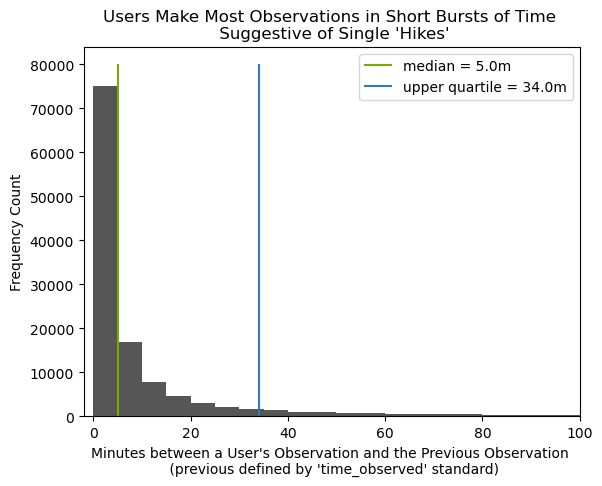

In [26]:
min_diff_visual = df_sp[df_sp["minute_diff"]<100]["minute_diff"]
median = round(min_diff_for_analysis.median(),0)
upper_quartile = round(min_diff_for_analysis.describe()[6],0)
plt.figure()
plt.hist(min_diff_visual, color = '#565656', bins = 20)
plt.vlines(median, 0, 80000, color ='#74ac00', label = f'median = {median}m')
plt.vlines(upper_quartile, 0, 80000, color = '#337AB7', label = f'upper quartile = {upper_quartile}m')
plt.legend()
plt.xlim(xmin = -2, xmax = 100)
plt.xlabel("Minutes between a User's Observation and the Previous Observation \n (previous defined by 'time_observed' standard)")
plt.ylabel("Frequency Count")
plt.title("Users Make Most Observations in Short Bursts of Time \n Suggestive of Single 'Hikes'")
plt.show()

In [27]:
meters_diff_for_analysis = df_sp[df_sp["km_diff"]>=0]["km_diff"]*1000
round(meters_diff_for_analysis.describe(),0)

count      148173.0
mean        28417.0
std        297703.0
min             0.0
25%            12.0
50%            94.0
75%          2676.0
max      17744088.0
Name: km_diff, dtype: float64

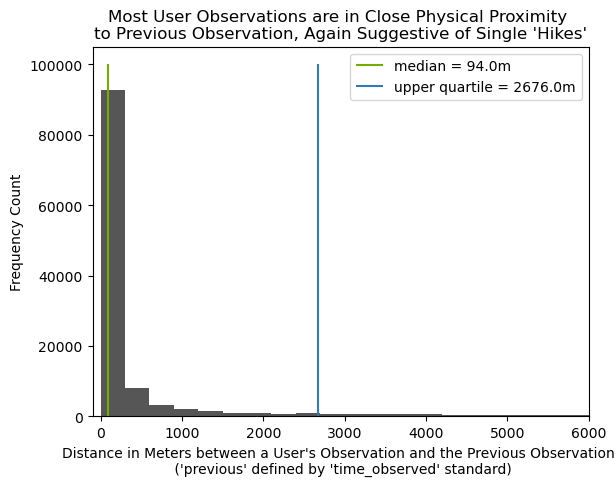

In [28]:
meters_diff_visual = df_sp[df_sp["km_diff"]<6]["km_diff"]*1000
median = round(meters_diff_for_analysis.median(),0)
upper_quartile = round(meters_diff_for_analysis.describe()[6],0)
plt.figure()
plt.hist(meters_diff_visual, color = '#565656', bins = 20)
plt.vlines(median, 0, 100000, color ='#74ac00', label = f'median = {median}m')
plt.vlines(upper_quartile, 0, 100000, color = '#337AB7', label = f'upper quartile = {upper_quartile}m')
plt.legend()
plt.xlim(xmin = -100, xmax = 6000)
plt.xlabel("Distance in Meters between a User's Observation and the Previous Observation \n ('previous' defined by 'time_observed' standard)")
plt.ylabel("Frequency Count")
plt.title("Most User Observations are in Close Physical Proximity \nto Previous Observation, Again Suggestive of Single 'Hikes'")
plt.show()

# Categorical Data

In [29]:
df_sp.describe(include = ["object"])

,quality_grade,species_guess,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name
count,148243,148243,148243,148243,148243,148243,148243
unique,3,29490,22909,18121,8,8326,16923
top,research,not stated,Lepidoptera,not stated,Plantae,not stated,not stated
freq,95080,18467,642,11583,81968,11737,31222


In [30]:
df_sp["quality_grade"].value_counts()

research    95080
needs_id    51635
casual       1528
Name: quality_grade, dtype: int64

In [31]:
# How many observations are not specified at a kingdom level?
(df_sp["taxon_kingdom_name"] == "not stated").sum()

111

In [32]:
# What is the scientific name given for observations without a stated taxon kingdom name?
df_sp[df_sp["taxon_kingdom_name"] == "not stated"]["scientific_name"].value_counts()

not stated    68
Life          43
Name: scientific_name, dtype: int64

In [33]:
# Is "Life" ever used as the "scientific name" when a taxon kingdom is specified?
df_sp[df_sp["scientific_name"] == "Life"]["taxon_kingdom_name"].value_counts()

not stated    43
Name: taxon_kingdom_name, dtype: int64

In [34]:
df_sp["taxon_kingdom_name"].value_counts()

Plantae       81968
Animalia      58343
Fungi          7525
Protozoa        237
not stated      111
Chromista        40
Bacteria         10
Viruses           9
Name: taxon_kingdom_name, dtype: int64

In [35]:
df_sp["scientific_name"].value_counts().head(10)

Lepidoptera            642
Magnoliopsida          492
Fungi                  373
Danaus plexippus       318
Bombus impatiens       313
Solidago               255
Carex                  245
Agaricales             243
Bombus griseocollis    225
Arisaema triphyllum    222
Name: scientific_name, dtype: int64

In [36]:
df_sp["common_name"].value_counts().head(11)

not stated                            11583
Butterflies and Moths                   642
dicots                                  492
Fungi Including Lichens                 373
Monarch                                 318
Common Eastern Bumble Bee               313
goldenrods                              254
Common Gilled Mushrooms and Allies      243
true sedges                             226
Brown-belted Bumble Bee                 225
Jack-in-the-Pulpit                      218
Name: common_name, dtype: int64

Names here match the categories for "scientific name"--these aren't always at the same taxon level, but at the most specific taxon level that there was identification agreement for. These "common_name" categories follow "scientific_name" for the most part but diverge a little. This is likely due to the flexibility / lack of agreement and ability for users to choose around "common_name". For example in the set below of Arisaema triphyllum, the four common names that are not Jack-in-the-Pulpit instead just have an "s" on the end. Keeping this data column clean is difficult and its purpose in iNaturalist is meant to help reach everyday users rather than be a clean, precise category. I will consider it a "user_engagement" category that allows for variability. 

In [37]:
df_sp[(df_sp["common_name"] != "Jack-in-the-Pulpit")\
 & (df_sp["scientific_name"] == "Arisaema triphyllum")]

,id,time_observed_at,user_id,created_at,quality_grade,num_identification_agreements,num_identification_disagreements,captive_cultivated,latitude,longitude,...,species_guess,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff
30658,74556265,2021-04-19 16:12:46+00:00,604,2021-04-19 20:33:36+00:00,needs_id,5,0,False,34.475646,-93.364415,...,Jack-in-the-Pulpits,Arisaema triphyllum,Jack-in-the-Pulpits,Plantae,Arisaema,not stated,0,0,20.266667,0.619012
58024,170157706,2023-06-29 18:28:23+00:00,518143,2023-06-29 19:10:10+00:00,needs_id,1,0,False,41.354808,-73.543237,...,Jack-in-the-Pulpits,Arisaema triphyllum,Jack-in-the-Pulpits,Plantae,Arisaema,not stated,0,0,11.016667,0.082232
105038,164734940,2023-05-30 15:26:21+00:00,1635190,2023-05-31 01:39:02+00:00,needs_id,2,0,False,42.548042,-72.584281,...,Jack-in-the-Pulpits,Arisaema triphyllum,Jack-in-the-Pulpits,Plantae,Arisaema,not stated,0,0,30.100000,0.116285
109503,168532093,2023-06-20 18:56:37+00:00,1750165,2023-06-20 18:58:09+00:00,needs_id,1,0,False,41.315888,-73.911486,...,Jack-in-the-Pulpits,Arisaema triphyllum,Jack-in-the-Pulpits,Plantae,Arisaema,not stated,0,0,1.516667,0.004933


In [38]:
df_sp["taxon_species_name"].value_counts().head(11)

not stated                   31222
Danaus plexippus               318
Bombus impatiens               313
Bombus griseocollis            225
Arisaema triphyllum            218
Notophthalmus viridescens      213
Anaxyrus americanus            209
Asclepias tuberosa             197
Sanguinaria canadensis         192
Achillea millefolium           184
Odocoileus virginianus         184
Name: taxon_species_name, dtype: int64

Common names: \
Monarch \
Common Eastern Bumble Bee \
Brown-belted Bumble Bee \
Jack in the Pulpit \
Eastern Newt \
American Toad \
Butterfly Milkweed \
Bloodroot \
Common Yarrow \
White_tailed_deer

Animals compete with plants for top species.

In [39]:
# What are the top plant species?
df_sp[df_sp["taxon_kingdom_name"] == "Plantae"]["taxon_species_name"].value_counts().head(11)

not stated                    11971
Arisaema triphyllum             218
Asclepias tuberosa              197
Sanguinaria canadensis          192
Achillea millefolium            184
Claytonia virginica             183
Asclepias syriaca               176
Maianthemum racemosum           176
Polystichum acrostichoides      166
Fagus grandifolia               166
Monotropa uniflora              164
Name: taxon_species_name, dtype: int64

Limiting to plants, adds: \
Virginia Springbeauty \
Common Milkweed \
Solomon's Plume \
Christmas Fern \
American Beech \
Ghostpipe

In [40]:
df_sp["taxon_genus_name"].nunique()

8326

In [41]:
df_sp["taxon_genus_name"].value_counts().head(11)

not stated        11737
Carex              1219
Asclepias          1137
Bombus             1082
Solidago            978
Viola               967
Quercus             932
Symphyotrichum      868
Acer                628
Lobelia             543
Rubus               528
Name: taxon_genus_name, dtype: int64

Plants, by far, make up top genus categories. \
Common names: \
Sedges \
Milkweed \
Bumble Bees \
Goldenrod \
Violets \
Oak \
American Asters \
Maples \
Lobelia \
Brambles (blackberry, raspberry...)

In [42]:
# What are the top plant species that are considered needing conservation protection?
df_sp[(df_sp["taxon_kingdom_name"] == "Plantae") \
      & (df_sp["taxon_geoprivacy_obscured"] == 1)]["taxon_species_name"]\
.value_counts().head(11)

not stated                  98
Sarracenia purpurea         71
Cypripedium parviflorum     29
Streptanthus glandulosus    28
Robinia viscosa             26
Calochortus umbellatus      23
Hydrastis canadensis        23
Trifolium reflexum          22
Sarracenia flava            21
Lespedeza leptostachya      21
Asplenium montanum          17
Name: taxon_species_name, dtype: int64

Purple Pitcher Plant \
Yellow Lady's Slipper \
Bristly Jewelflower \
Clammy Locust \
Oakland Mariposa Lily \
Goldenseal \
Buffalo Clover \
Yellow Pitcher Plant \
Prairie Lespedeza \
Mountain Spleenwort

In [43]:
#How many plant observations in this set are considered needing conservation protection?
num_taxon_obscured_plants = ((df_sp["taxon_kingdom_name"] == "Plantae") \
      & (df_sp["taxon_geoprivacy_obscured"] == 1)).sum()
percent = round(100*num_taxon_obscured_plants/df_sp.shape[0],2)

print(f'{num_taxon_obscured_plants} \
plant observations are marked as having an obscured taxon geoprivacy, \
which is {percent}% of this dataset.')

2131 plant observations are marked as having an obscured taxon geoprivacy, which is 1.44% of this dataset.


# Basic Linear Interpolation Toward Target Species

In [44]:
# indices of rows for target species
target_index = df_sp[(df_sp["taxon_species_name"] == "Lobelia spicata") \
                     & (df_sp["public_positional_accuracy"] <= 30)].index

In [45]:
# storing lat/lon for target species for later validation
validation_dict = {}
for ind in target_index:
    validation_dict[ind] = (df_sp.loc[ind, "latitude"], df_sp.loc[ind, "longitude"])

Using scikit learn's [haversine function ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html) to approximate distance between two lat/lon points.

In [46]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
def dist_in_meters(lat1, lon1, lat2, lon2): 
    '''
    Takes the latitude and longitude of two different locations 
    and returns the approximate distance in meters between the two.
    
    Arguments:
    lat1 = latitude of first location
    lon1 = longitude of first location
    lat2 = latitude of 2nd location
    lon2 = longitude of 2nd location
   
    Returns: 
    Estimated distance in m between the two lat/lon locations 
    
    '''
    location1 = [lat1, lon1] # locations to lists
    location2 = [lat2, lon2]
    loc1_rad = [radians(deg) for deg in location1] #locations to radians
    loc2_rad = [radians(deg) for deg in location2]
    result = haversine_distances([loc1_rad, loc2_rad]) #haversine distance
    dist = result[0][1] * 6371000  # multiply by Earth radius in m to get m
    return dist

In [47]:

# creates list of columns for interpolation df
columns_for_interpolation = ["latitude", "longitude", "min_from_target"]
entries = len(target_index)
num_above_and_below = 25
summary_df= pd.DataFrame(index = range(entries), columns=["original_index", "best_num_datapoints", "best_lat", "best_lon", "best_dist"])

for i in range(entries):
    # target_info
    min_row = target_index[i] - num_above_and_below
    max_row = target_index[i] + num_above_and_below
    target_time = df_sp.loc[target_index[i], "time_observed_at"]
    best_stats = {'best_num': 0, 'best_lat': 0, 'best_lon': 0, 'best_dist': 100}
    
    # subset of entries around target, with relevant columns,
    # a new column for minutes away from target and reindexed
    subset = df_sp.loc[min_row:max_row, ("id", "latitude", "longitude", "time_observed_at")] # chosen rows and columns
    subset["min_from_target"] = 0 # new column for minutes away from target
    for j in range(min_row, max_row + 1):
        min_away = (subset.loc[j, "time_observed_at"] - target_time).total_seconds() / 60
        subset.loc[j, "min_from_target"] = min_away
    
    subset.drop(target_index[i], inplace = True) #dropping target and resetting index
    subset.reset_index(inplace = True)
    
# creates list of indices above and below target value given number of datapoints we want above 
# with presumption of number of above = number below
# builds loop where only two rows grabbed for interpolation, then 4, then 6...
    best_dist = 26000
    desired_indices = []
    for num in range(num_above_and_below):
        desired_indices.append(num_above_and_below - 1 - num)
        desired_indices.append(num_above_and_below + num)
        
# creates dataframe for only the chosen rows surrounding the target
        lin_reg_df = subset.loc[desired_indices, columns_for_interpolation]  

# creates independent columns with constant for lin reg analysis
        X_withconstant = sm.add_constant(lin_reg_df["min_from_target"])

# creates dependent columns for latitude and longitude
        yLAT = lin_reg_df["latitude"]
        yLON = lin_reg_df["longitude"]

# instantiates and fits one OLS for dependent of latitude and another for longitude
        lin_reg_resultsLAT = sm.OLS(yLAT, X_withconstant).fit()
        lin_reg_resultsLON = sm.OLS(yLON, X_withconstant).fit() 

# calculates how far prediction is from actual
        meters_from_actual = dist_in_meters(lin_reg_resultsLAT.params[0], lin_reg_resultsLON.params[0], validation_dict[target_index[i]][0], validation_dict[target_index[i]][1])
        summary_df.loc[i,"original_index"] = target_index[i]
        if meters_from_actual < best_dist:
            best_dist = meters_from_actual
            summary_df.loc[i,"best_dist"] = meters_from_actual
            summary_df.loc[i,"best_num_datapoints"] = (num + 1)*2
            summary_df.loc[i,"best_lat"] = lin_reg_resultsLAT.params[0]
            summary_df.loc[i,"best_lon"] = lin_reg_resultsLON.params[0]

In [48]:
summary_df = summary_df.apply(pd.to_numeric)

In [49]:
round(summary_df.describe(),2)

,original_index,best_num_datapoints,best_lat,best_lon,best_dist
count,100.00,96.00,96.00,96.00,96.00
mean,90174.22,5.12,39.34,-85.67,734.18
std,40238.72,7.64,3.85,7.53,1915.69
min,1402.00,2.00,30.39,-96.46,0.00
25%,50126.25,2.00,36.00,-92.35,14.97
50%,97538.50,2.00,40.60,-87.86,45.54
75%,122588.50,4.50,41.85,-79.09,268.39
max,148040.00,50.00,48.68,-72.05,9753.98


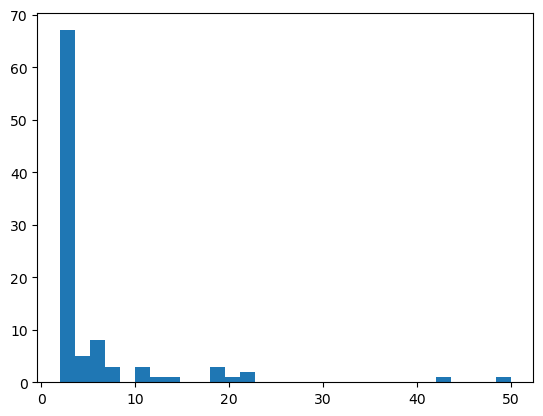

In [50]:
plt.figure()
plt.hist(summary_df["best_num_datapoints"], bins = 30)
plt.show()

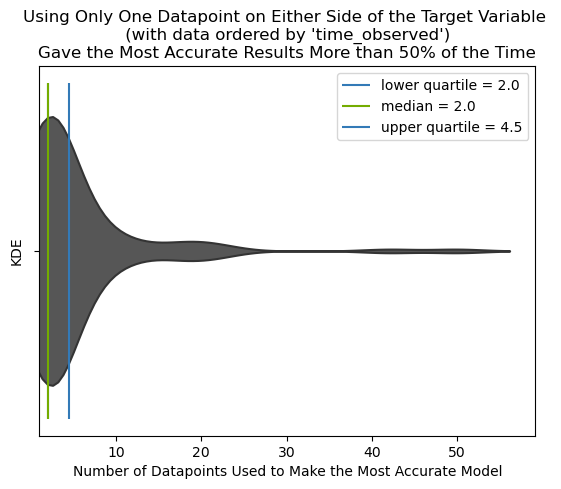

In [51]:
lower_quartile = summary_df["best_num_datapoints"].describe()[4]
median = summary_df["best_num_datapoints"].describe()[5]
upper_quartile = summary_df["best_num_datapoints"].describe()[6]
plt.figure()
sns.violinplot(x = summary_df["best_num_datapoints"], color = '#565656', inner = None, linecolor = '#f16f3a')
plt.xlabel("Number of Datapoints Used to Make the Most Accurate Model")
plt.ylabel("KDE")
plt.title("Using Only One Datapoint on Either Side of the Target Variable \n (with data ordered by 'time_observed') \nGave the Most Accurate Results More than 50% of the Time")
plt.vlines(lower_quartile, -0.5, 0.5, color = '#337AB7', label = f'lower quartile = {lower_quartile}')
plt.vlines(median, -0.5, 0.5, color = '#74ac00', label = f'median = {median}')
plt.vlines(upper_quartile, -0.5, 0.5, color = '#337AB7', label = f'upper quartile = {upper_quartile}')
plt.xlim(xmin = 1)
plt.legend()
plt.show()

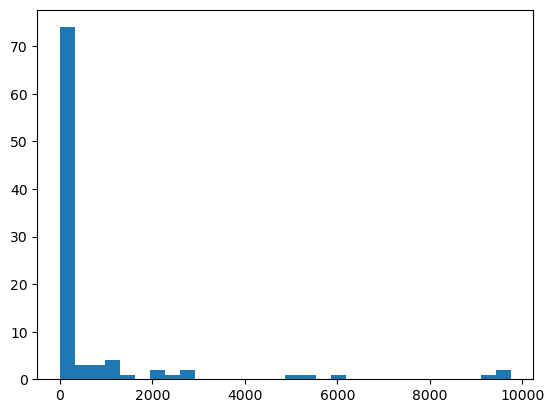

In [52]:
plt.figure()
plt.hist(summary_df["best_dist"], bins = 30)
plt.show()

In [53]:
i = 21
target_time = df_sp.loc[target_index[i], "time_observed_at"]
time_before = df_sp.loc[target_index[i] - 1, "time_observed_at"]
lat_before = df_sp.loc[target_index[i] - 1, "latitude"]
lon_before = df_sp.loc[target_index[i] - 1, "longitude"]
time_after = df_sp.loc[target_index[i] + 1, "time_observed_at"]
lat_after = df_sp.loc[target_index[i] + 1, "latitude"]
lon_after = df_sp.loc[target_index[i] + 1, "longitude"]
    
predicted_lat = (lat_after - lat_before) * (target_time - time_before) / (time_after - time_before) + lat_before
predicted_lon = (lon_after - lon_before) * (target_time - time_before) / (time_after - time_before) + lon_before

print(lat_before, lon_before)
print(lat_after, lon_after)
print(predicted_lat, predicted_lon)

48.074781 -96.459961
48.076369 -96.460321
48.076332069767055 -96.46031262790659


In [54]:
target_index

Int64Index([  1402,  26691,  26692,  26700,  28328,  28335,  30018,  30024,
             30025,  30034,  30823,  30860,  36636,  38806,  39184,  39530,
             39778,  40516,  41478,  43925,  46887,  47036,  48547,  49618,
             49941,  50188,  51869,  51870,  57149,  61227,  64949,  65622,
             65936,  68673,  69598,  72444,  72522,  86045,  86957,  87213,
             87506,  88306,  88634,  88947,  90616,  92187,  93786,  95212,
             97169,  97338,  97739,  98238,  98521,  98992,  99170,  99173,
            102746, 102836, 107971, 108650, 109553, 109783, 110000, 110150,
            110254, 110787, 112320, 112428, 112531, 113018, 114343, 117317,
            119481, 122453, 122522, 122788, 122960, 123453, 123459, 128205,
            135366, 136827, 136896, 137354, 139299, 139315, 140214, 140310,
            140377, 145569, 145832, 146175, 146194, 146531, 147382, 147412,
            147445, 147520, 147746, 148040],
           dtype='int64')

In [55]:

# Requires these same variables from above:
#columns_for_interpolation = ["latitude", "longitude", "min_from_target"]

new_summary_df= pd.DataFrame(index = range(entries), columns=["original_index", "lat_pred", "lon_pred", "dist_from_target"])
i = 0
for ind in target_index:
    # necessary info for linear interpolation
    target_time = df_sp.loc[ind, "time_observed_at"]
    time_before = df_sp.loc[ind - 1, "time_observed_at"]
    lat_before = df_sp.loc[ind - 1, "latitude"]
    lon_before = df_sp.loc[ind - 1, "longitude"]
    time_after = df_sp.loc[ind + 1, "time_observed_at"]
    lat_after = df_sp.loc[ind + 1, "latitude"]
    lon_after = df_sp.loc[ind + 1, "longitude"]
    
    if time_after != time_before:
        predicted_lat = (lat_after - lat_before) * (target_time - time_before) / (time_after - time_before) + lat_before
        predicted_lon = (lon_after - lon_before) * (target_time - time_before) / (time_after - time_before) + lon_before
    else:
        predicted_lat = lat_before
        predicted_lon = lon_before
    
    

# calculates how far prediction is from actual
    meters_from_actual = dist_in_meters(predicted_lat, predicted_lon, validation_dict[ind][0], validation_dict[ind][1])
    new_summary_df.loc[i,"original_index"] = ind
    new_summary_df.loc[i,"dist_from_target"] = meters_from_actual
    new_summary_df.loc[i,"lat_pred"] = predicted_lat
    new_summary_df.loc[i,"lon_pred"] = predicted_lon
    i += 1

In [56]:
new_summary_df = new_summary_df.apply(pd.to_numeric)
new_summary_df.describe()

,original_index,lat_pred,lon_pred,dist_from_target
count,100.00000,100.000000,100.000000,100.000000
mean,90174.22000,39.470330,-85.791549,8675.698696
std,40238.72219,3.848546,7.611222,52586.207026
min,1402.00000,30.386804,-96.460313,0.000002
25%,50126.25000,35.999214,-92.354248,18.561420
50%,97538.50000,40.642265,-87.865177,56.020568
75%,122588.50000,42.023809,-79.129501,688.505063
max,148040.00000,48.677715,-72.072920,517082.794130


In [60]:
new_summary_df[new_summary_df["dist_from_target"]<=76].shape[0] * 100 / new_summary_df.shape[0]

55.0

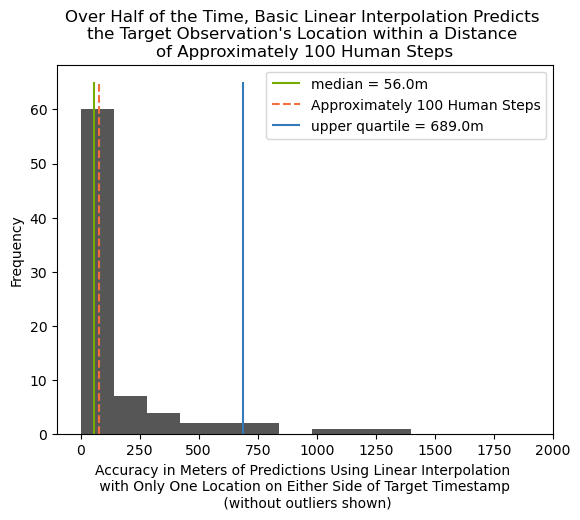

In [58]:
lower_quartile = round(new_summary_df["dist_from_target"].describe()[4],0)
median = round(new_summary_df["dist_from_target"].describe()[5],0)
upper_quartile = round(new_summary_df["dist_from_target"].describe()[6],0)

plt.hist(new_summary_df[new_summary_df["dist_from_target"]<=2000]["dist_from_target"], color = '#565656')
plt.xlabel("Accuracy in Meters of Predictions Using Linear Interpolation \n with Only One Location on Either Side of Target Timestamp \n (without outliers shown)")
plt.ylabel("Frequency")
plt.title("Over Half of the Time, Basic Linear Interpolation Predicts \nthe Target Observation's Location within a Distance \nof Approximately 100 Human Steps")
#plt.vlines(lower_quartile, 0, 65, color = '#74ac00', label = f'lower quartile = {lower_quartile}m')
plt.vlines(median, 0, 65, color = '#74ac00', label = f'median = {median}m')
plt.vlines(76, 0, 65, color = '#f16f3a' , label = "Approximately 100 Human Steps", linestyle = "dashed")
plt.vlines(upper_quartile, 0, 65, color = '#337AB7', label = f'upper quartile = {upper_quartile}m')
plt.xlim(xmin = -100, xmax = 2000)
plt.legend()
plt.show()


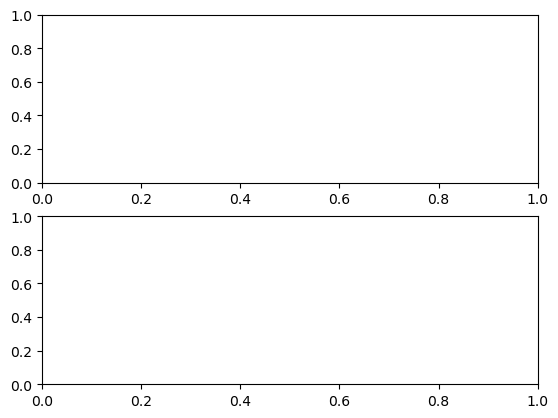

In [59]:

fig, axs = plt.subplots(2, 1)

#sns.boxplot(x = new_summary_df["dist_from_target"], color = '#74ac00', width = 20)